# PyTorch Computer Vision

In [1]:
# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# TorchVision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print( torch.__version__)
print( torchvision.__version__)

2.2.2+cu121
0.17.2+cu121


## 1. Dataset

In [2]:
train_data = datasets.FashionMNIST(
	root="data",			# download dir
	train=True,				# include train dataset
	download=True,			# download?
	transform=ToTensor(),	# conversion of data
	target_transform=None	# conversion of labels
)

test_data = datasets.FashionMNIST(
	root="data",
	train=False,
	download=True,
	transform=ToTensor(),
	target_transform=None
)

In [3]:
len( train_data), len( test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes

class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
class_to_idx = train_data.class_to_idx

class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

Image Shape: torch.Size([1, 28, 28]) -> [ color channel, height, width]
Image Label: 9 - Ankle boot


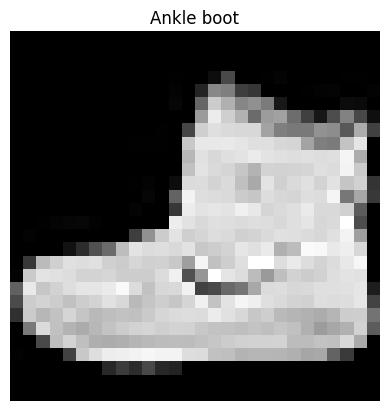

In [7]:
image, label = train_data[ 0]

print( f"Image Shape: { image.shape} -> [ color channel, height, width]")
print( f"Image Label: { label} - { class_names[ label]}")

plt.imshow( image.squeeze(), cmap="gray")
plt.title( class_names[ label])
plt.axis( False)
plt.show()

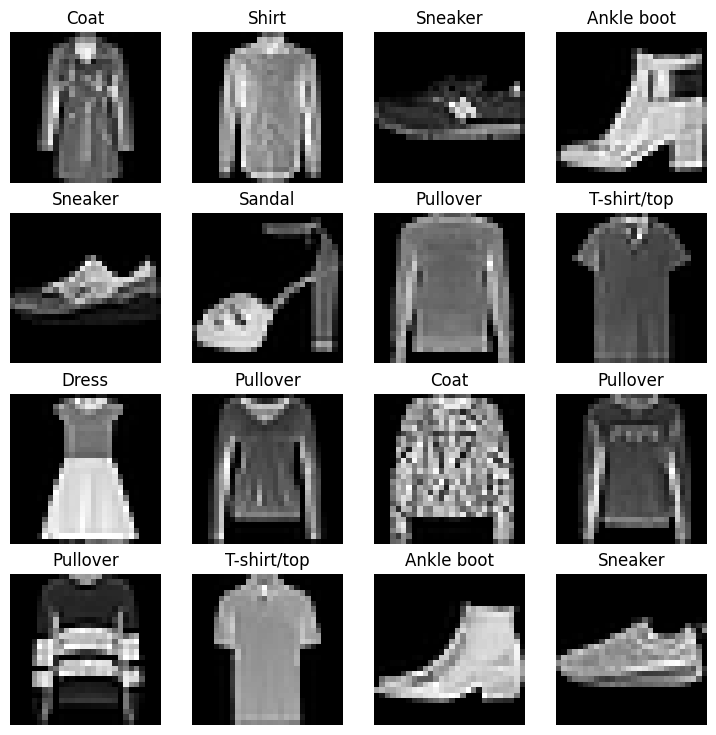

In [8]:
fig = plt.figure( figsize=( 9, 9))
rows, cols = 4, 4

for i in range( 1, rows * cols + 1):
	rand_idx = torch.randint( 0, len( train_data), size=[ 1]).item()
	img, lbl = train_data[ rand_idx]
	fig.add_subplot( rows, cols, i)
	plt.imshow( img.squeeze(), cmap="gray")
	plt.title( class_names[ lbl])
	plt.axis( False)

## 2. Prepare DataLoader

In [9]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [10]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
	dataset=train_data,
	batch_size=BATCH_SIZE,
	shuffle=True
)

test_dataloader = DataLoader(
	dataset=test_data,
	batch_size=BATCH_SIZE,
	shuffle=False
)

In [11]:
print( f"DataLoaders: { train_dataloader, test_dataloader}")
print( f"Length of train_dataloader: { len( train_dataloader)} batches of { BATCH_SIZE}")
print( f"Length of test_dataloader: { len( test_dataloader)} batches of { BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001E28DDAB250>, <torch.utils.data.dataloader.DataLoader object at 0x000001E28E07B750>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [12]:
train_feature_batch, train_label_batch = next( iter( train_dataloader))

train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

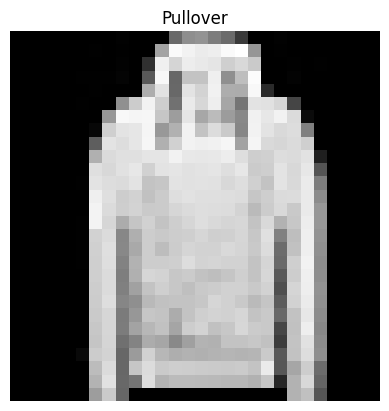

Image size: torch.Size([1, 28, 28])
Label: 2, label size: torch.Size([])


In [13]:
rand_idx = torch.randint( 0, len( train_feature_batch), size=[ 1]).item()

img, lbl = train_feature_batch[ rand_idx], train_label_batch[ rand_idx]

plt.imshow( img.squeeze(), cmap="gray")
plt.title( class_names[ lbl])
plt.axis( False)
plt.show()
print( f"Image size: { img.shape}")
print( f"Label: { lbl}, label size: { lbl.shape}")

## 3. Model 0: Build a baseline model

In [14]:
flatten_model = nn.Flatten()

x = train_feature_batch[ 0]

output = flatten_model( x)

print( f"Shape before flattening: { x.shape} -> [color channel, height, width]")
print( f"Shape after flattening: { output.shape} -> [color channel, height * width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color channel, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color channel, height * width]


In [15]:
class FashionMnistModelV0( nn.Module):
	def __init__( self, input_shape: int, hidden_unit: int, output_shape: int):
		super().__init__()

		self.layer_stack = nn.Sequential(
			nn.Flatten(),
			nn.Linear( in_features=input_shape, out_features=hidden_unit),
			nn.Linear( in_features=hidden_unit, out_features=output_shape)
		)

	def forward( self, x):
		return self.layer_stack( x)

In [16]:
torch.manual_seed( 42)

model_0 = FashionMnistModelV0(
	input_shape=28 * 28,
	hidden_unit=10,
	output_shape=len( class_names)
).to( "cpu")

model_0

FashionMnistModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
dummy_x = torch.rand( [ 1, 1, 28, 28])

model_0( dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1. Setup Loss, optimizer and evaluation metrics

In [18]:
import requests
from pathlib import Path

if Path( "helper_functions.py").is_file():
	print( "helper_functions.py already exists, skipping download...")
else:
	print( "Downloading helper_functions.py")
	request = requests.get( "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

	with open( "helper_functions.py", "wb") as f:
		f.write( request.content)

helper_functions.py already exists, skipping download...


In [19]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( params=model_0.parameters(), lr=0.1)

### 3.2. Create a function to time our experiment

In [20]:
from timeit import default_timer as timer

def print_train_time( start: float, end: float, device: torch.device = None):

	total_time = end - start
	
	print( f"Train time on { device}: { total_time:.3f} seconds")

	return total_time
	
start_time = timer()
# some code...
end_time = timer()

print_train_time( start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


2.1599999854515772e-05

### 3.3. Creating a training loop and train the model on batches of data

1. Loop Through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out what's happening
5. Time it all

In [21]:
from tqdm.auto import tqdm

torch.manual_seed( 42)

train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm( range( epochs)):
	print( f"\nEpoch: { epoch}\n----------")

	### Training
	train_loss, train_acc = 0, 0

	for batch, ( X, y) in enumerate( train_dataloader):
		model_0.train()

		# 1. Forward pass
		y_pred = model_0( X)

		# 2. Calculate the loss (per batch)
		loss = loss_fn( y_pred, y)
		train_loss += loss # accumulate train loss
		
		# 2.5 Calculate the accuracy (per batch)
		train_acc += accuracy_fn( y_true=y, y_pred=y_pred.argmax( dim=1))

		# 3. Optimizer zero grad
		optimizer.zero_grad()

		# 4. Loss backward
		loss.backward()

		# 5. Optimizer step
		optimizer.step()

		if batch % 400 == 0:
			print( f"Looked at { batch * len( X)}/{ len( train_dataloader.dataset)} samples.")

	# Calculate loss average per batch
	train_loss /= len( train_dataloader)

	# Calculate accuracy average per batch
	train_acc /= len( train_dataloader)

	### Testing
	test_loss, test_acc = 0, 0
	model_0.eval()

	with torch.inference_mode():
		for X_test, y_test in test_dataloader:
			# 1. Forward pass
			test_pred = model_0( X_test)

			# 2. Calculate loss
			test_loss += loss_fn( test_pred, y_test)

			# 3. Calculate accuracy
			test_acc += accuracy_fn( y_true=y_test, y_pred=test_pred.argmax( dim=1))

		# Calculate test loss average per batch
		test_loss /= len( test_dataloader)

		# Calculate the test acc average per batch
		test_acc /= len( test_dataloader)

	print( f"\nTrain loss: { train_loss:.4f} | Train Acc: { train_acc:.2f}% | Test Loss: { test_loss:.4f} | Test Acc: { test_acc:.2f}%")

train_time_end_on_cpu = timer()

total_train_time_model_0 = print_train_time( start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str( next( model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0
----------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Train Acc: 79.17% | Test Loss: 0.5095 | Test Acc: 82.04%

Epoch: 1
----------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Train Acc: 83.32% | Test Loss: 0.4799 | Test Acc: 83.20%

Epoch: 2
----------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Train Acc: 84.05% | Test Loss: 0.4766 | Test Acc: 83.43%
Train time on cpu: 36.348 seconds


## 4. Setup device agnostic-code (for using GPU if there is one) 

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 5. Make predictions and get results

In [23]:
def eval_model( model: torch.nn.Module,
			    data_loader: torch.utils.data.DataLoader,
				loss_fn: torch.nn.Module,
				accuracy_fn,
				device: torch.device = device):
	loss, acc = 0, 0

	model.eval()

	with torch.inference_mode():
		for X, y in tqdm( data_loader):
			X, y = X.to( device), y.to( device)
			
			y_pred = model( X)

			loss += loss_fn( y_pred, y)
			acc += accuracy_fn( y_true=y, y_pred=y_pred.argmax( dim=1))

		loss /= len( data_loader)
		acc /= len( data_loader)

	return {
		"model_name": model.__class__.__name__,
		"model_loss": loss.item(),
		"model_acc": acc
	}

In [24]:
torch.manual_seed( 42)
model_0_results = eval_model( model=model_0,
							  data_loader=test_dataloader,
							  loss_fn=loss_fn,
							  accuracy_fn=accuracy_fn,
							  device="cpu")

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMnistModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## 6. Building a better model with non-linearity

In [25]:
class FashionMnistModelV1( nn.Module):
	def __init__( self,
			  	  input_shape: int,
				  hidden_units: int,
				  output_shape: int):
		super().__init__()

		self.layer_stack = nn.Sequential(
			nn.Flatten(),
			nn.Linear( in_features=input_shape,
			 		   out_features=hidden_units),
			nn.ReLU(),
			nn.Linear( in_features=hidden_units,
			 		   out_features=output_shape),
			# nn.ReLU()
		)

	def forward( self, x: torch.Tensor):
		return self.layer_stack( x)

In [26]:
torch.manual_seed( 42)

model_1 = FashionMnistModelV1( input_shape=28 * 28,
							   hidden_units=10,
							   output_shape=len( class_names)).to( device)

model_1, next( model_1.parameters()).device

(FashionMnistModelV1(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
   )
 ),
 device(type='cuda', index=0))

### 6.1. Setup loss function, optimzer and evaluation metrics

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( params=model_1.parameters(), lr=0.1)

### 6.2. Functionizing training and evaluation/testing loop

In [28]:
def train_step( model: torch.nn.Module,
			    dataloader: torch.utils.data.DataLoader,
				loss_fn: torch.nn.Module,
				optimizer: torch.optim.Optimizer,
				accuracy_fn,
				device: torch.device = device):
	
	train_loss, train_acc = 0, 0

	model.train()

	for batch, ( X, y) in enumerate( dataloader):

		X, y = X.to( device), y.to( device)

		# 1. Forward pass
		y_pred = model( X)

		# 2. Calculate the loss and accuracy (per batch)
		loss = loss_fn( y_pred, y)
		train_loss += loss # accumulate train loss
		train_acc += accuracy_fn( y_true=y,
						   	 	  y_pred=y_pred.argmax( dim=1))

		# 3. Optimizer zero grad
		optimizer.zero_grad()

		# 4. Loss backward
		loss.backward()

		# 5. Optimizer step
		optimizer.step()

	# Calculate loss/acc average per batch
	train_loss /= len( dataloader)
	train_acc /= len( dataloader)

	print( f"Train loss: { train_loss:.5f} | Train Acc: { train_acc:.4f}%")

def test_step( model: torch.nn.Module,
			   dataloader: torch.utils.data.DataLoader,
			   loss_fn: torch.nn.Module,
			   accuracy_fn,
			   device: torch.device = device):
	
	test_loss, test_acc = 0, 0
	
	model.eval()

	with torch.inference_mode():
		for X, y in dataloader:
			X, y = X.to( device), y.to( device)

			# 1. Forward pass
			y_pred = model( X)

			# 2. Calculate loss/acc
			test_loss += loss_fn( y_pred, y)
			test_acc += accuracy_fn( y_true=y,
						   			 y_pred=y_pred.argmax( dim=1))

		# Calculate test loss/acc average per batch
		test_loss /= len( dataloader)
		test_acc /= len( dataloader)

		print( f"Test Loss: { test_loss:.5f} | Test Acc: { test_acc:.4f}%")


In [29]:
torch.manual_seed( 42)

train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm( range( epochs)):
	print( f"\nEpoch: { epoch}\n----------")

	train_step( model=model_1,
				dataloader=train_dataloader,
				loss_fn=loss_fn,
				optimizer=optimizer,
				accuracy_fn=accuracy_fn)
	
	test_step( model=model_1,
			   dataloader=test_dataloader,
			   loss_fn=loss_fn,
			   accuracy_fn=accuracy_fn)
	
train_time_end_on_gpu = timer()

total_train_time_model_1 = print_train_time( start=train_time_start_on_gpu,
											 end=train_time_end_on_gpu,
											 device=device)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0
----------
Train loss: 0.64607 | Train Acc: 77.1700%
Test Loss: 0.53855 | Test Acc: 80.7608%

Epoch: 1
----------
Train loss: 0.48094 | Train Acc: 82.9433%
Test Loss: 0.49390 | Test Acc: 82.4581%

Epoch: 2
----------
Train loss: 0.44689 | Train Acc: 84.1633%
Test Loss: 0.45746 | Test Acc: 83.9856%
Train time on cuda: 48.420 seconds


In [30]:
model_1_results = eval_model( model=model_1,
							  data_loader=test_dataloader,
							  loss_fn=loss_fn,
							  accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [31]:
total_train_time_model_0, total_train_time_model_1

(36.34825589999946, 48.42010019999998)

In [32]:
model_0_results, model_1_results

({'model_name': 'FashionMnistModelV0',
  'model_loss': 0.47663888335227966,
  'model_acc': 83.42651757188499},
 {'model_name': 'FashionMnistModelV1',
  'model_loss': 0.45746350288391113,
  'model_acc': 83.98562300319489})

## 7. Building a Convolutional Neural Network (CNN)

In [33]:
class FashionMNISTModelV2( nn.Module):
	"""
	Model architecture that replicates the TinyVGG
	"""

	def __init__( self, input_shape: int, hidden_units: int, output_shape: int):
		super().__init__()

		self.conv_block_1 = nn.Sequential(
			nn.Conv2d( in_channels=input_shape,
			 		   out_channels=hidden_units,
					   kernel_size=3,
					   stride=1,
					   padding=1),
			nn.ReLU(),
			nn.Conv2d( in_channels=hidden_units,
					   out_channels=hidden_units,
					   kernel_size=3,
					   stride=1,
					   padding=1),
			nn.ReLU(),
			nn.MaxPool2d( kernel_size=2)
		)

		self.conv_block_2 = nn.Sequential(
			nn.Conv2d( in_channels=hidden_units,
			 		   out_channels=hidden_units,
					   kernel_size=3,
					   stride=1,
					   padding=1),
			nn.ReLU(),
			nn.Conv2d( in_channels=hidden_units,
					   out_channels=hidden_units,
					   kernel_size=3,
					   stride=1,
					   padding=1),
			nn.ReLU(),
			nn.MaxPool2d( kernel_size=2)
		)

		self.classifier = nn.Sequential(
			nn.Flatten(),
			nn.Linear( in_features=hidden_units * 7 * 7,
			 		   out_features=output_shape)
		)

	def forward( self, x):
		x = self.conv_block_1( x)
		# print( x.shape)
		x = self.conv_block_2( x)
		# print( x.shape)	# used for getting conv_block_2 output shape
		x = self.classifier( x)
		return x

In [34]:
torch.manual_seed( 42)

model_2 = FashionMNISTModelV2( input_shape=1,
							   hidden_units=10,
							   output_shape=len( class_names)).to( device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7.1. Stepping through `nn.Conv2d()`

In [35]:
torch.manual_seed( 42)

images = torch.randn( size=( 32, 3, 64, 64))

test_image = images[ 0]

print( f"Image batch shape: { images.shape}")
print( f"Single image shape: { test_image.shape}")
print( f"test image: { test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
test image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.

In [36]:
conv_layer = nn.Conv2d( in_channels=3,
					    out_channels=10,
						kernel_size=3,
						stride=1,
						padding=0)

conv_output = conv_layer( test_image)

In [37]:
conv_output.shape

torch.Size([10, 62, 62])

### 7.2. Stepping through `nn.MaxPool2d()`

In [38]:
max_pool_layer = nn.MaxPool2d( kernel_size=2)

max_pool_output = max_pool_layer( conv_output)

In [39]:
max_pool_output.shape

torch.Size([10, 31, 31])

In [40]:
torch.manual_seed( 42)

random_tensor = torch.randn( size=( 1, 1, 2, 2))

max_pool_layer = nn.MaxPool2d( kernel_size=2)

max_pool_tensor = max_pool_layer( random_tensor)

print( f"Random tensor:\n { random_tensor}")
print( f"Random tensor shape: { random_tensor.shape}")
print( f"Max pool tensor:\n { max_pool_tensor}")
print( f"Max pool tensor shape: { max_pool_tensor.shape}")

Random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])
Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [41]:
rand_image_tensor = torch.randn( size=( 1, 28, 28))

rand_image_tensor.shape

torch.Size([1, 28, 28])

In [42]:
model_2( rand_image_tensor.unsqueeze( 0).to( device))

tensor([[ 0.0424, -0.0839,  0.0839, -0.0463,  0.0053,  0.0437,  0.0025,  0.0108,
         -0.0158, -0.0177]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 7.3. Setup a loss function and optimizer for `model 2`

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( params=model_2.parameters(), lr=0.1)

### 7.4. Training and testing `model_2`

In [44]:
torch.manual_seed( 42)
torch.cuda.manual_seed( 42)

train_time_start_model_2 = timer()

epochs = 3

for epoch in tqdm( range( epochs)):
	print( f"Epoch: { epoch}\n-------")

	train_step( model=model_2,
				dataloader=train_dataloader,
				loss_fn=loss_fn,
				optimizer=optimizer,
				accuracy_fn=accuracy_fn,
				device=device)
	
	test_step( model=model_2,
		   	   dataloader=test_dataloader,
			   loss_fn=loss_fn,
			   accuracy_fn=accuracy_fn,
			   device=device)

train_time_end_model_2 = timer()

total_train_time_model_2 = print_train_time( start=train_time_start_model_2,
											 end=train_time_end_model_2,
											 device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59983 | Train Acc: 78.1883%
Test Loss: 0.39086 | Test Acc: 86.1821%
Epoch: 1
-------
Train loss: 0.36346 | Train Acc: 86.9383%
Test Loss: 0.34970 | Test Acc: 87.2604%
Epoch: 2
-------
Train loss: 0.32246 | Train Acc: 88.2067%
Test Loss: 0.31833 | Test Acc: 88.4784%
Train time on cuda: 60.340 seconds


In [45]:
model_2_results = eval_model( model=model_2,
							  data_loader=test_dataloader,
							  loss_fn=loss_fn,
							  accuracy_fn=accuracy_fn,
							  device=device)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31832730770111084,
 'model_acc': 88.47843450479233}

## 8. Compare model results and training time

In [46]:
import pandas as pd

compare_results = pd.DataFrame( [ model_0_results, model_1_results, model_2_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMnistModelV0,0.476639,83.426518
1,FashionMnistModelV1,0.457464,83.985623
2,FashionMNISTModelV2,0.318327,88.478435


In [47]:
compare_results[ "train_time"] = [ total_train_time_model_0,
								   total_train_time_model_1,
								   total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,train_time
0,FashionMnistModelV0,0.476639,83.426518,36.348256
1,FashionMnistModelV1,0.457464,83.985623,48.420100
2,FashionMNISTModelV2,0.318327,88.478435,60.340364


Text(0, 0.5, 'model')

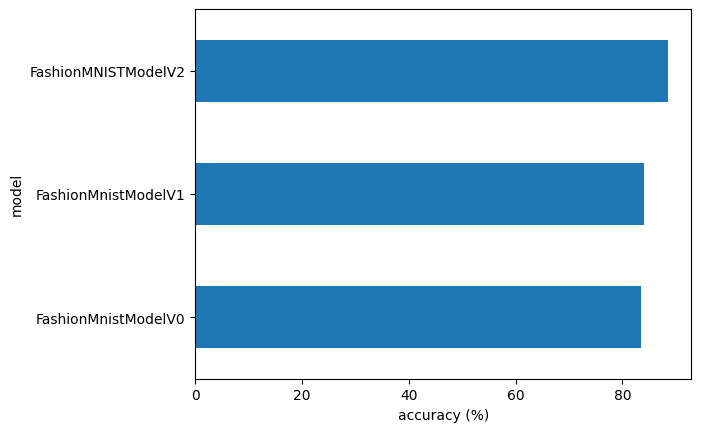

In [48]:
compare_results.set_index( "model_name")[ "model_acc"].plot( kind="barh")

plt.xlabel( "accuracy (%)")
plt.ylabel( "model")

Text(0, 0.5, 'model')

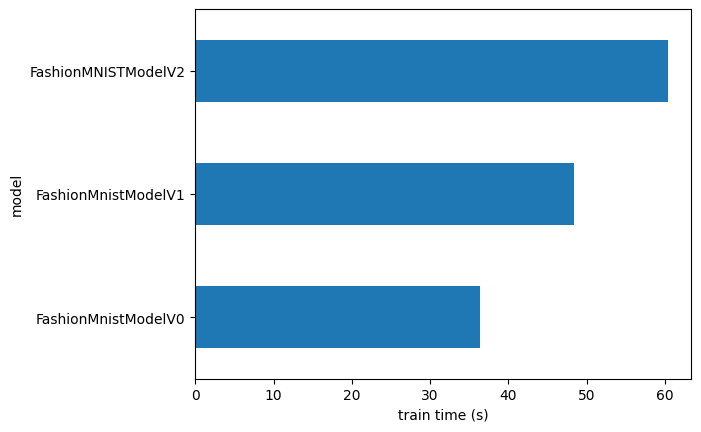

In [49]:
compare_results.set_index( "model_name")[ "train_time"].plot( kind="barh")

plt.xlabel( "train time (s)")
plt.ylabel( "model")

## 9. Make and evaluate random prediction with best model

In [50]:
def make_predictions( model: torch.nn.Module,
					  data: list,
					  device: torch.device = device):
	pred_probs = []

	model.eval()

	with torch.inference_mode():
		for sample in data:

			sample = torch.unsqueeze( sample, dim=0).to( device)

			pred_logits = model( sample)

			pred_prob = torch.softmax( pred_logits.squeeze(), dim=0)

			pred_probs.append( pred_prob.cpu())

	return torch.stack( pred_probs)

In [51]:
import random
# random.seed( 42)

test_samples = []
test_labels = []

for sample, label in random.sample( list( test_data), k=9):

	test_samples.append( sample)
	test_labels.append( label)

test_samples[ 0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Pullover')

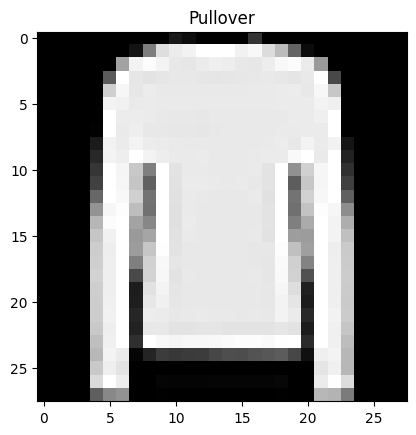

In [52]:
plt.imshow( test_samples[ 0].squeeze(), cmap="gray")
plt.title( class_names[ test_labels[ 0]])

In [53]:
pred_probs = make_predictions( model=model_2,
							   data=test_samples)

pred_probs[ :2]

tensor([[3.4587e-03, 4.2870e-06, 9.8591e-01, 3.0746e-04, 2.2450e-03, 7.4558e-07,
         8.0366e-03, 2.2057e-07, 3.6775e-05, 4.5309e-07],
        [4.9462e-04, 4.2697e-05, 7.0245e-04, 1.3744e-03, 9.9638e-01, 3.1428e-06,
         8.2847e-04, 8.9008e-08, 1.7647e-04, 1.5149e-07]])

In [54]:
pred_classes = pred_probs.argmax( dim=1)

pred_classes[ :2]

tensor([2, 4])

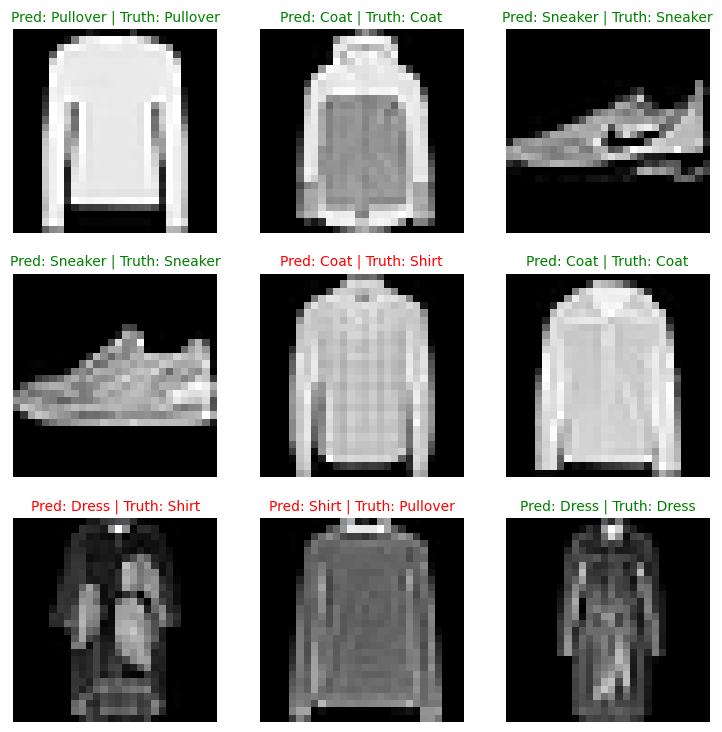

In [55]:
plt.figure( figsize=( 9, 9))

nrows = 3
ncols = 3

for i, sample in enumerate( test_samples):
	plt.subplot( nrows, ncols, i + 1)

	plt.imshow( sample.squeeze(), cmap="gray")

	plt.axis( False)

	pred_label = class_names[ pred_classes[ i]]

	truth_label = class_names[ test_labels[ i]]

	title_text = f"Pred: { pred_label} | Truth: { truth_label}"

	if pred_label == truth_label:
		plt.title( title_text, fontsize=10, c="g")
	else:
		plt.title( title_text, fontsize=10, c="r")

## 10. Making a confusion matrix

In [56]:
y_preds = []

model_2.eval()

with torch.inference_mode():
	for X, y in tqdm( test_dataloader, desc="Making Predictions..."):
		X, y = X.to( device), y.to( device)

		y_logit = model_2( X)

		y_pred = torch.softmax( y_logit.squeeze(), dim=0).argmax( dim=1)

		y_preds.append( y_pred.cpu())

y_pred_tensor = torch.cat( y_preds)
y_pred_tensor[ :10]

Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [57]:
try:
	import torchmetrics, mlxtend
	print( f"mlxtend version: { mlxtend.__version__}")
	assert int( mlxtend.__version__.split( ".")[ 1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
	%pip install -q torchmetrics -U mlxtend
	import torchmetrics, mlxtend
	print( f"mlxtend version: { mlxtend.__version__}")


mlxtend version: 0.23.1


In [58]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix( task="multiclass",
						   num_classes=len( class_names))
confmat_tensor = confmat( preds=y_pred_tensor,
						  target=test_data.targets)

confmat_tensor

tensor([[634,   6,  44,  77,  10,   1, 221,   0,   7,   0],
        [ 12, 899,   3,  57,  20,   1,   5,   0,   3,   0],
        [  8,   3, 802,  15,  93,   0,  73,   0,   6,   0],
        [ 29,   9,  28, 856,  37,   0,  30,   0,  10,   1],
        [  5,   8, 115,  47, 711,   0, 107,   0,   7,   0],
        [  7,   1,   2,   2,   1, 870,   4,  49,  48,  16],
        [ 70,   6, 127,  69,  83,   1, 629,   0,  15,   0],
        [  1,   1,   0,   0,   0,  32,   0, 921,   7,  38],
        [  9,   2,  21,  12,  14,   8,  25,   6, 902,   1],
        [  0,   1,   0,   3,   0,  26,   1,  99,  15, 855]])

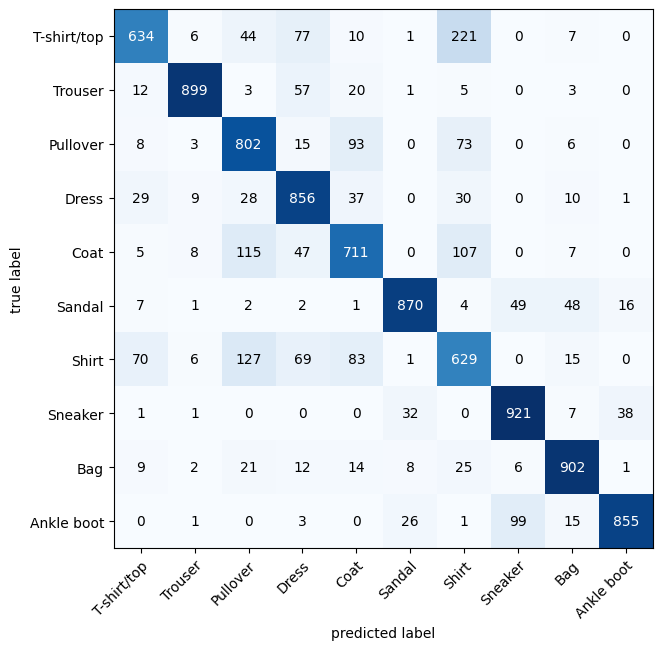

In [59]:
fig, ax = plot_confusion_matrix(
	conf_mat=confmat_tensor.numpy(),
	class_names=class_names,
	figsize=( 10, 7)
)

## 11. Save and Load best performing model

In [60]:
from pathlib import Path

MODEL_PATH = Path( "models")
MODEL_PATH.mkdir( parents=True, exist_ok=True)

MODEL_NAME = "pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print( f"Saving model to: { MODEL_SAVE_PATH}")
torch.save( obj=model_2.state_dict(),
		    f=MODEL_SAVE_PATH)

Saving model to: models\pytorch_computer_vision_model_2.pth


In [61]:
torch.manual_seed( 42)

loaded_model_2 = FashionMNISTModelV2( input_shape=1, hidden_units=10, output_shape=10)

loaded_model_2.load_state_dict( torch.load( f=MODEL_SAVE_PATH))

loaded_model_2.to( device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [62]:
torch.manual_seed( 42)

loaded_model_2_results = eval_model(
	model=loaded_model_2,
	data_loader=test_dataloader,
	loss_fn=loss_fn,
	accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31832730770111084,
 'model_acc': 88.47843450479233}

In [63]:
torch.isclose( torch.tensor( model_2_results[ "model_loss"]),
			   torch.tensor( loaded_model_2_results[ "model_loss"]),
			   atol=1e-8)

tensor(True)